# Neural Networks for Eddy Covarinace

In [1]:
## Import some standard packages and define a few functions
import time
import importlib
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs

dbNames = {
    'Clean/SecondStage/TA_1_1_1':'TA',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/P_1_1_1':'P',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'USTAR',
    'Clean/SecondStage/TS_1':'TS_1',
    'Clean/SecondStage/TS_2':'TS_2',
    'Clean/SecondStage/TS_3':'TS_3',
    'Clean/SecondStage/wind_speed':'U',
    'Clean/SecondStage/wind_dir':'dir',
    'Met/MET_WaterLevel_Avg':'WTD_raw',
    'Clean/SecondStage/WTD_1_1_1':'WTD',
}

Local = '/mnt/c/Users/User/PostDoc_Work/database/'
Remote = '/mnt/w/'

Dir = Remote

Site = 'BB'

read_new = False
if read_new == True:
    Data = ReadDB.get_Traces(Site,list(dbNames.keys()),Dir=Dir)
    Data = Data.rename(columns=dbNames)
    Data.to_csv(f'temp/{Site}_VPD.csv')

else:
    Data = pd.read_csv(f'temp/{Site}_VPD.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')


2023-05-06 10:31:07.360259: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Pre-processing

In [2]:
importlib.reload(ReadDB)

Data['VPD'] = MiscFuncs.Calc_VPD(Data['TA'],Data['RH'])
Data['DOY'] = Data.index.dayofyear

inputs = ['PPFD','VPD','TS_1','Rand']
target = ['FCO2']

Data['Rand']=np.random.random(Data['FCO2'].values.shape)
Data['Rand100']=Data['Rand']*100

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.rain('P',thresh=1)
filter.MAD(z=7)
filter.uStar('USTAR',u_thresh=0.05)

Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()

Clean_Data = filter.df.copy()

               FCO2          FCH4
count  37260.000000  42498.000000
mean      -0.333153     52.984234
std        4.312031     69.966599
min      -49.348000   -199.917200
25%       -1.711623      9.618972
50%       -0.131327     34.761661
75%        0.749001     90.470169
max       49.777348    695.056900


# Make Scenarios

In [6]:
def Config_Defauls(run,name):
    run['config']['Name']=name
    run['config']['Nodes']=[64]
    run['config']['Activation']=['relu']
    run['config']['epochs']=250
    run['config']['batch_size']=32
    run['config']['Norm']=True
    run['config']['N_models']=3
    run['config']['RF_comp']=True

    run['Training'] = {}
    run['Evaluation'] = {}
    run['Full'] = {}
    return(run)

    

Model_Runs = {
    'VPD_Estimate':{
        'config':{
            'target':['VPD'],
            'inputs':['TA','RH'],
            },
        },
    'Noisy_Data':{
        'config':{
            'target':['FCO2'],
            'inputs':['PPFD','VPD','TS_1','TS_2','USTAR'],
            },
        },
    'Feature_Detection':{
        'config':{
            'target':['FCO2_Clean'],
            'inputs':['PPFD','VPD','TS_1','TS_2','TS_3','U','dir','Rand'],
            },
        },
}

for key in Model_Runs.keys():
    Model_Runs[key] = Config_Defauls(Model_Runs[key],key)
    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    Training,Validation = MiscFuncs.makeMask(Data.loc[Data[target+inputs].dropna().index],
                                             target,dropOut=.2)
    print(Training[target+inputs].shape,Validation[target+inputs].shape)
    Model_Runs[key]['Training']['X'] = Training[inputs].values
    Model_Runs[key]['Training']['Y'] = Training[target].values.flatten()
    Model_Runs[key]['Evaluation']['X'] = Validation[inputs].values
    Model_Runs[key]['Evaluation']['Y'] = Validation[target].values.flatten()
    Model_Runs[key]['Full']['X'] = Data[inputs].values
    Model_Runs[key]['Full']['Y'] = Data[target].values.flatten()
    Model_Runs[key]['config']['mean'] = Data[inputs].mean().values
    Model_Runs[key]['config']['variance'] = Data[inputs].std().values**2

(112083, 3) (28021, 3)
(29756, 6) (7439, 6)
(13945, 9) (3486, 9)


## Build and train model

In [8]:
importlib.reload(NNetFuncs)

# run = 'Noisy_Data'

Runs = ['VPD_Estimate']#,'Feature_Detection']
for run in Runs:
    config = Model_Runs[run]['config']
    Training = Model_Runs[run]['Training']

    NNetFuncs.make_Dense_model(config)
    NNetFuncs.train_model(config,Training)

Model: "VPD_Estimate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 normalization (Normalizatio  (None, 2)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


2023-05-06 10:36:36.536135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 10:36:36.594401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 10:36:36.594451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 10:36:36.595204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

None


2023-05-06 10:36:39.945020: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Training Time:
 390.82  Seconds

Training RF Model
Training Time:
 17.38  Seconds


# Run and evaluate trained model

In [9]:
importlib.reload(NNetFuncs)

# Runs = []

for run in Runs:
    config = Model_Runs[run]['config']
    Data = Model_Runs[run]['Evaluation']
    full_out=NNetFuncs.run_Model(config,Data)


NN Model
 Validation metrics (ensemble mean): 
r2 =  0.99997 
RMSE =  0.0211
Run Time:
 1.39  Seconds


RF Model 
Validation metrics: 
r2 =  0.99993 
RMSE =  0.00102
(100, 2)
Run Time:
 2.33  Seconds


In [12]:
NN_Output = pd.read_csv(f'{run}/model_output.csv',index_col=[0])

NN_Output.head()


,target,y_bar,y_CI95,TA,dy_dTA,dy_dTA_CI95,RH,dy_dRH,dy_dRH_CI95,dy_dTA_norm,dy_dTA_norm_CI95,dy_dRH_norm,dy_dRH_norm_CI95
0,0.270034,0.300944,0.042382,-5.533580,0.024451,0.009073,93.360290,-0.043456,0.012337,0.169464,0.062880,-0.673114,0.191090
1,0.285102,0.316917,0.046563,-5.642763,0.024451,0.009073,92.931300,-0.043456,0.012337,0.169464,0.062880,-0.673114,0.191090
2,0.629921,0.642112,0.022682,-1.000655,0.041666,0.027850,88.957664,-0.049247,0.007925,0.288776,0.193021,-0.762807,0.122758
3,1.632419,1.630041,0.018399,1.472991,0.101518,0.016948,76.081710,-0.068318,0.009420,0.703594,0.117466,-1.058213,0.145905
4,2.057611,2.053821,0.018041,3.112818,0.135750,0.011745,73.177100,-0.094088,0.006172,0.940851,0.081401,-1.457380,0.095608


In [13]:
RF_Output = pd.read_csv(f'{run}/random_forest_output.csv',index_col=[0])

RF_Output.head()


,target,y_bar,y_CI95
0,0.270034,0.268923,0.000334
1,0.285102,0.284683,0.000834
2,0.629921,0.627934,0.001479
3,1.632419,1.628556,0.005303
4,2.057611,2.055004,0.004972


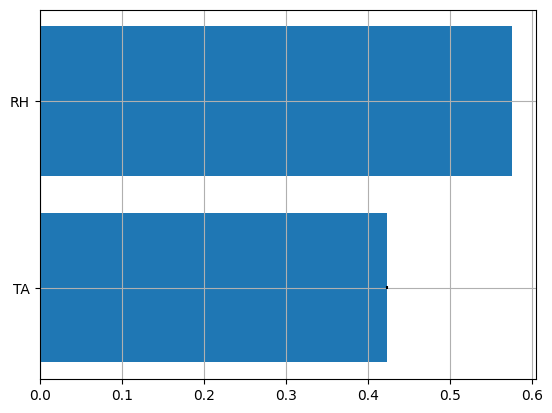

In [16]:
NN_RI = pd.read_csv(f'{run}/model_RI.csv',index_col=[0])
mod = '_norm'

NN_RI = NN_RI.sort_values(by=f'RI{mod}_bar',ascending=True)
fig,ax=plt.subplots()

ax.barh(NN_RI.index,NN_RI[f'RI{mod}_bar'],yerr=NN_RI[f'RI{mod}_CI95'])
ax.grid()


In [14]:
RF_Output = pd.read_csv(f'{run}/random_forest_output.csv',index_col=[0])

RF_Output.head()

,target,y_bar,y_CI95
0,0.270034,0.268923,0.000334
1,0.285102,0.284683,0.000834
2,0.629921,0.627934,0.001479
3,1.632419,1.628556,0.005303
4,2.057611,2.055004,0.004972


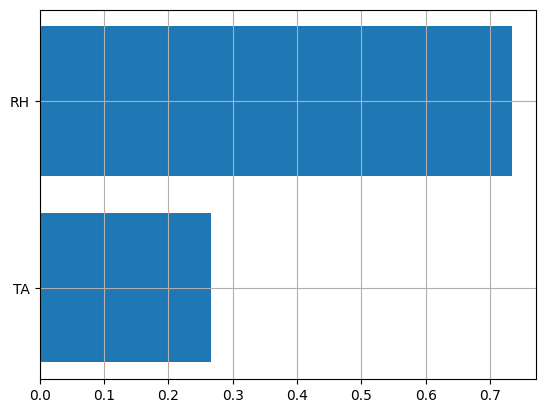

In [15]:
RF_RI = pd.read_csv(f'{run}/random_forest_RI.csv',index_col=[0])

mod = ''

RF_RI = RF_RI.sort_values(by = f'RI{mod}_bar')


fig,ax=plt.subplots()
ax.barh(RF_RI.index,RF_RI[f'RI{mod}_bar'],yerr=RF_RI[f'RI{mod}_CI95'])
ax.grid()

## Relative influence of features

# Plot derivatives

KeyError: "None of [Index(['dy_dPPFDnorm'], dtype='object')] are in the [columns]"

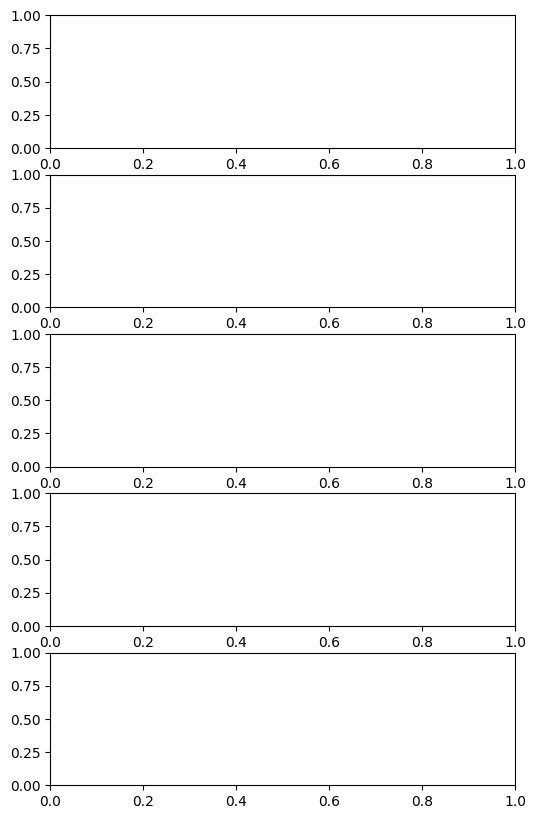

In [8]:
npi=len(RI.index)

fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

mod = 'norm'

for i,xi in enumerate(Model_Runs[run]['config']['inputs']):
    df = MiscFuncs.byInterval(Mean_Output,f'{xi}',[f'dy_d{xi}{mod}'],bins=10)
    PlotHelpers.CI_Plot(axes[i],df,f'dy_d{xi}{mod}')
plt.tight_layout()

# Format the training data

KeyError: 'USTAR'

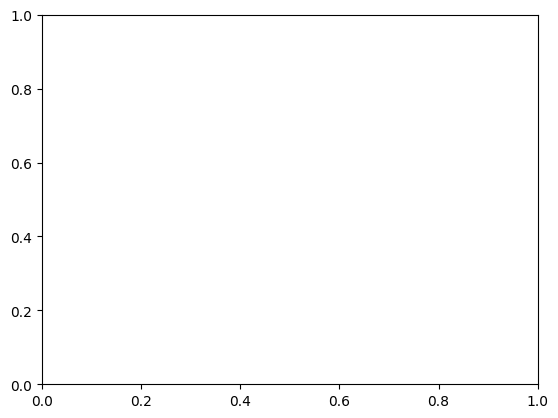

In [ ]:
fig,ax=plt.subplots()
# ax.scatter(Mean_Output['target'],Mean_Output['y_bar'])

# fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

# for i,xi in enumerate(Model_Runs[run]['config']['inputs']):
xi='USTAR'
df = MiscFuncs.byInterval(Mean_Output.loc[Mean_Output['PPFD']<100].copy(),
                            f'{xi}',[f'dy_d{xi}{mod}'],bins=100)
PlotHelpers.CI_Plot(ax,df,f'dy_d{xi}{mod}')

In [31]:

NNetFuncs.make_SHL_model(input=Data[inputs],Norm=True,m=m,v=v)

T1 = time.time()
NNetFuncs.train_model(Examples[Set][f'X_train_{norm}'],
                      Examples[Set]['Y_train'],
                      Sub_Models=3
                      )

T2 = time.time()
print(f'Complted Training in: {T2-T1} seconds')


RI,out_dx = NNetFuncs.predict_Model(Examples[Set][f'X_train_{norm}'],
                                    x_raw=Examples[Set][f'X_train_{norm}'],
                                    target=Examples[Set]['Y_train'],
                                    Norm=False)

print(metrics.r2_score(out_dx['target'],out_dx['y_bar']))
print(metrics.mean_squared_error(out_dx['target'],out_dx['y_bar'])**.5)


Model: "SHL_NN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 normalization (Normalizatio  (None, 4)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Complted Training in: 27.077788591384888 seconds
0.8493241038623638
0.6012874685983414


['PPFD', 'VPD', 'TS_1', 'Rand']
0.8493241038623638
0.6012874685983414
         RI     RI_95   RI_norm  RI_norm_95
0  0.015806  0.000284  0.547886    0.009838
1  0.152305  0.005963  0.057751    0.002261
2  0.520502  0.009551  0.384450    0.007055
3  0.311387  0.035706  0.009912    0.001137


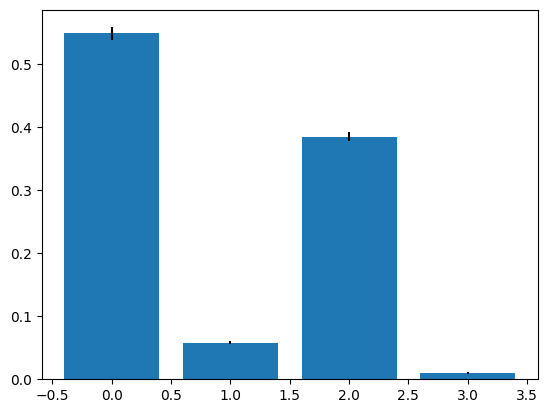

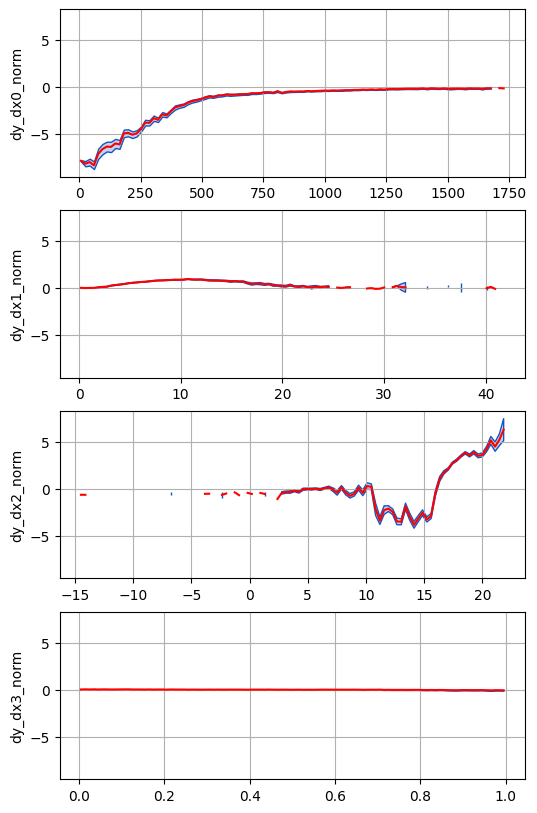

In [34]:
# print(inputs)

# importlib.reload(PlotHelpers)
# importlib.reload(MiscFuncs)
# importlib.reload(NNetFuncs)

# RI,out_dx = NNetFuncs.predict_Model(Examples[Set][f'X_train_{norm}'],
#                                     x_raw=Examples[Set][f'X_train_{norm}'],
#                                     target=Examples[Set]['Y_train'],
#                                     Norm=True)

print(metrics.r2_score(out_dx['target'],out_dx['y_bar']))
print(metrics.mean_squared_error(out_dx['target'],out_dx['y_bar'])**.5)

mod = '_norm'

fig,ax=plt.subplots()
ax.bar(RI.index,RI[f'RI{mod}'],yerr=RI[f'RI{mod}_95'])

print(RI)

npi=4

fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

for i in range(npi):
    df = MiscFuncs.byInterval(out_dx,f'x{i}',[f'dy_dx{i}{mod}'],bins=100)
    PlotHelpers.CI_Plot(axes[i],df,f'dy_dx{i}{mod}')